
![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)





[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/finance-nlp/05.1.Training_Financial_NER.ipynb)

#🔎 Training Financial NER


#🎬 Installation

In [ ]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using [my.johnsnowlabs.com](https://my.johnsnowlabs.com/) SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to [my.johnsnowlabs.com](https://my.johnsnowlabs.com/)
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

##📌 Start Spark Session

In [ ]:
from johnsnowlabs import nlp, finance
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

##📌 Training a custom NerModel


📚The model was trained in the available [Tweets dataset](https://www.kaggle.com/omermetinn/tweets-about-the-top-companies-from-2015-to-2020), with data from 2015 to 2020. 

If your appliation needs different entities than the provided pretrained models can identify, what you can do is to train a new model that fits your requirements. To do that you first need to collect and label enough data and put them in the CoNLL 2003 format. If you are not sure how to annotate (label) text data and prepare it in the CoNLL 2003 format, try our free tool [Annotation Lab](https://nlp.johnsnowlabs.com/docs/en/alab/quickstart), where you can easily label text data and export in the correct format for training.

For our purposes here, we will use a sample file annotated by our team.

###✔️ CoNLL Data Prep 


In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/finance-nlp/data/conll_noO.conll

In [ ]:
with open("./conll_noO.conll") as f:
    train_txt =f.read()

print(train_txt[:500])

( NN NN O
d NN NN O
) NN NN O
OF NN NN O
THE NN NN O
SECURITIES NN NN O
EXCHANGE NN NN O
ACT NN NN O
OF NN NN O
1934 NN NN O
For NN NN O
the NN NN O
annual NN NN O
period NN NN O
ended NN NN O
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
March NNP NNP B-FISCAL_YEAR
31 NNP NNP I-FISCAL_YEAR
, NNP NNP I-FISCAL_YEAR
2021 NNP NNP I-FISCAL_YEAR
☐ NN NN O
TRANSITION NN NN O
REPORT NN NN O
UNDER NN NN O
SECTION NN NN O
13 NN NN O
OR NN NN O
15 


The pipeline is similar to the `NerModel` one, but instead of a `AnnotatorModel`, we use an `AnnotatorApproach` object to train the model. If these concepts of annotator and model is not familiar to you, please review the documentation [here](https://nlp.johnsnowlabs.com/docs/en/concepts).

To load the data into spark dataframe, you can use the [CoNLL](https://nlp.johnsnowlabs.com/docs/en/training#conll-dataset) helper.

In [ ]:
from sparknlp.training import CoNLL

finance_data = CoNLL().readDataset(spark, "conll_noO.conll")
finance_data.selectExpr(
    "text", "token.result as tokens", "pos.result as pos", "label.result as label"
).show(3, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                               |tokens                                                                                                                                                                             |pos               

In [ ]:
finance_data.count()

1637

In [ ]:
finance_data.columns

['text', 'document', 'sentence', 'token', 'pos', 'label']

Checking the labels we have:

In [ ]:
finance_data.select(F.explode("label.result")).distinct().show(50, False)

+------------------+
|col               |
+------------------+
|I-PROFIT_INCREASE |
|B-PROFIT          |
|B-AMOUNT          |
|I-PROFIT          |
|B-PERCENTAGE      |
|B-PROFIT_DECLINE  |
|B-PROFIT_INCREASE |
|I-DATE            |
|I-AMOUNT          |
|B-EXPENSE         |
|B-EXPENSE_INCREASE|
|I-EXPENSE_INCREASE|
|I-PROFIT_DECLINE  |
|O                 |
|B-CURRENCY        |
|I-PERCENTAGE      |
|B-FISCAL_YEAR     |
|I-FISCAL_YEAR     |
|B-DATE            |
|I-EXPENSE_DECREASE|
|B-EXPENSE_DECREASE|
|I-EXPENSE         |
+------------------+



In [ ]:
finance_data.select(
    F.explode(F.arrays_zip(finance_data.token.result, finance_data.label.result)).alias(
        "cols"
    )
).select(
    F.expr("cols['0']").alias("token"), F.expr("cols['1']").alias("ground_truth")
).groupBy(
    "ground_truth"
).count().orderBy(
    "count", ascending=False
).show(
    100, truncate=False
)

+------------------+-----+
|ground_truth      |count|
+------------------+-----+
|O                 |51912|
|I-DATE            |1932 |
|I-FISCAL_YEAR     |1812 |
|B-DATE            |1797 |
|B-AMOUNT          |1466 |
|B-CURRENCY        |1461 |
|I-AMOUNT          |1134 |
|B-FISCAL_YEAR     |605  |
|I-EXPENSE_INCREASE|546  |
|I-EXPENSE_DECREASE|390  |
|B-PERCENTAGE      |350  |
|I-PROFIT_INCREASE |288  |
|I-EXPENSE         |280  |
|B-EXPENSE_INCREASE|274  |
|I-PROFIT          |228  |
|B-EXPENSE_DECREASE|191  |
|B-PROFIT_INCREASE |164  |
|B-EXPENSE         |150  |
|B-PROFIT          |122  |
|I-PROFIT_DECLINE  |93   |
|B-PROFIT_DECLINE  |58   |
|I-PERCENTAGE      |12   |
+------------------+-----+



📚The CoNLL data already have the columns `document`, `sentence` and `token` that are needed to create the NER model, the only one that is missing is the Embeddings. So let's use the same embedding pretrained model as before to train this new one, but you could use any Embedding model instead (check [SparkNLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Embeddings) for a list of available embedding models).

###✔️ Using Bert Embeddings

In [ ]:
bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


Split the data into train and test sets

In [ ]:
train_data, test_data = finance_data.randomSplit([0.8, 0.2], seed=42)

We transform the test data and store it into a parquet file so we can use it during training for testing.

In [ ]:
bert_embeddings.transform(test_data).write.mode("overwrite").parquet(
    "test_data_embeddings.parquet"
)

📚Declare the train annotator using the `NerApproach`. In this example, we will train for only 2 epochs to illustrate how to use the annotator without spending too much time waiting the model to finish training, but we recommend to use 5-50 epochs depending on your application to obtain a proper model.

In [ ]:
nerTagger = finance.NerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(2)\
    .setLr(0.003)\
    .setBatchSize(32)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setEnableMemoryOptimizer(True)\
    .setOutputLogsPath('ner_logs') # if not set, logs will be written to ~/annotator_logs
#   .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated the 4.1 NerDL-Graph.ipynb notebook or you can use TFGraphBuilder annotator    
#   .setEnableMemoryOptimizer(True)\ # if you have a limited memory and a large conll file, you can set this True to train batch by batch

ner_pipeline = nlp.Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [ ]:
%%time

ner_model = ner_pipeline.fit(train_data)

CPU times: user 11.1 s, sys: 1.26 s, total: 12.4 s
Wall time: 33min 46s


In [ ]:
import os

log_files = os.listdir("./ner_logs")
with open("./ner_logs/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.003 - batch size: 32 - labels: 22 - chars: 96 - training examples: 1076


Epoch 1/2 started, lr: 0.003, dataset size: 1076


Epoch 1/2 - 459.17s - loss: 1156.4308 - avg training loss: 34.01267 - batches: 34
Quality on validation dataset (20.0%), validation examples = 215
time to finish evaluation: 365.12s
Total validation loss: 77.2285	Avg validation loss: 8.5809
label	 tp	 fp	 fn	 prec	 rec	 f1
I-AMOUNT	 147	 1	 8	 0.9932432	 0.9483871	 0.970297
B-AMOUNT	 209	 7	 2	 0.9675926	 0.9905213	 0.9789227
B-DATE	 194	 20	 100	 0.90654206	 0.65986395	 0.7637795
I-DATE	 278	 65	 39	 0.8104956	 0.8769716	 0.8424242
I-EXPENSE	 0	 0	 21	 0.0	 0.0	 0.0
B-PROFIT_INCREASE	 0	 1	 26	 0.0	 0.0	 0.0
B-EXPENSE	 0	 0	 15	 0.0	 0.0	 0.0
I-PERCENTAGE	 0	 0	 2	 0.0	 0.0	 0.0
I-PROFIT_DECLINE	 0	 0	 19	 0.0	 0.0	 0.0
I-PROFIT	 0	 0	 33	 0.0	 0.0	 0.0
B-CURRENCY	 210	 2	 0	 0.990566	 1.0	 0.99526066
I-

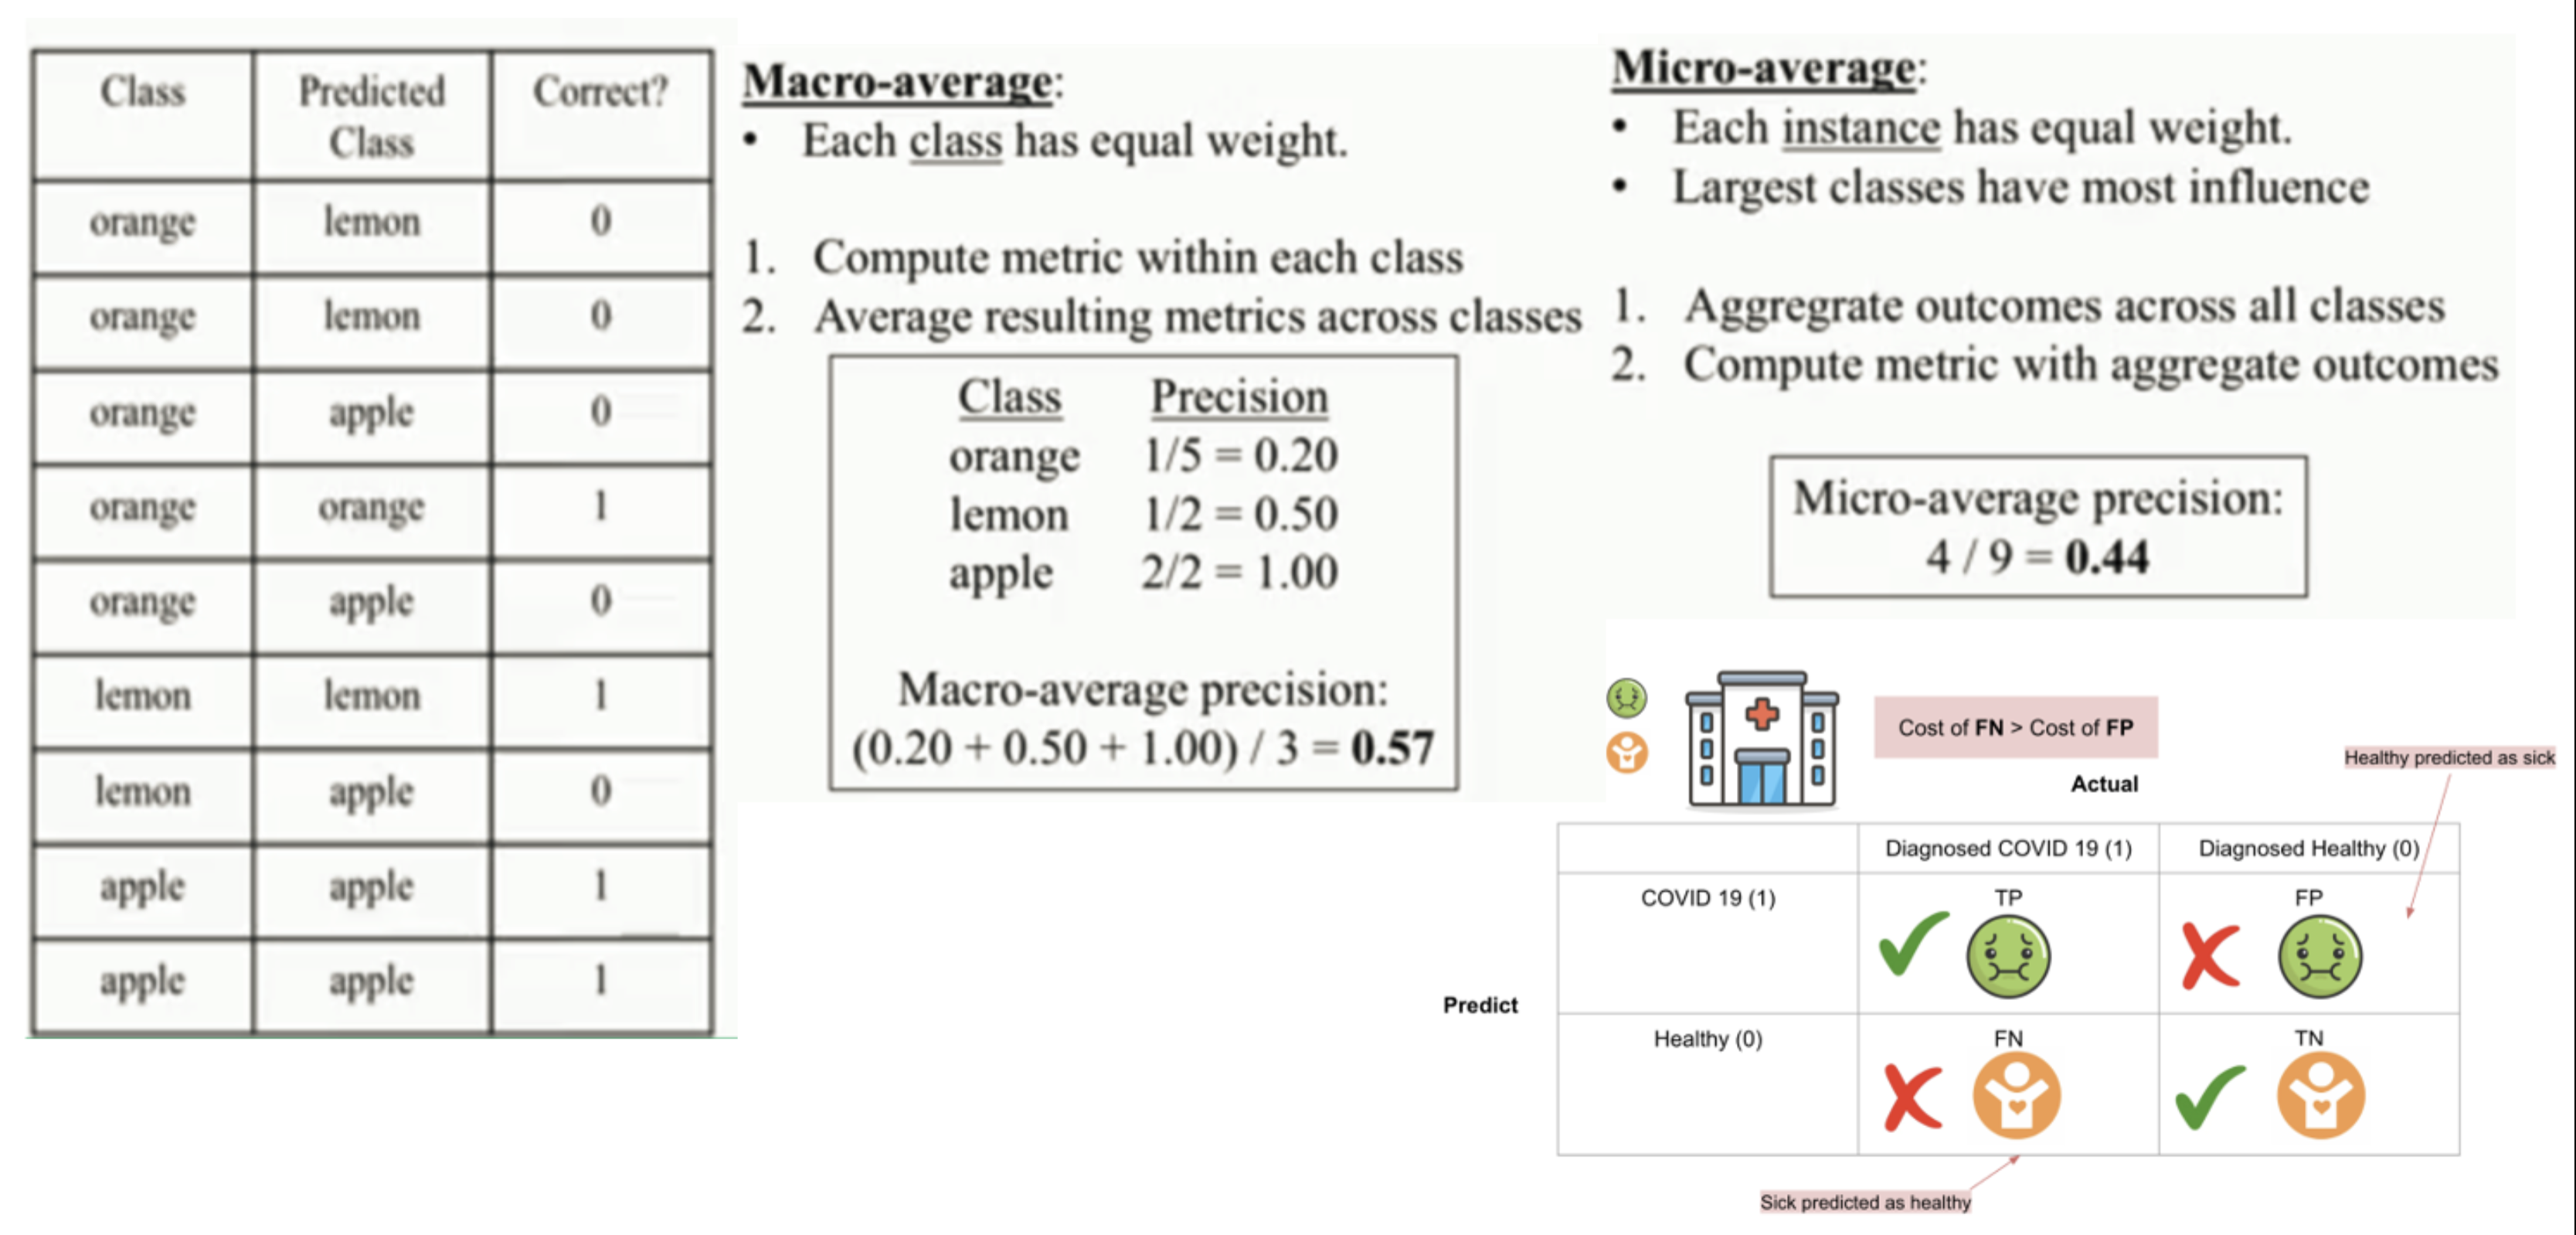

###✔️ Splitting Dataset Into Train and Test Set

Also we will use `.setTestDataset('test_data_embeddings.parquet')` for checking test-loss values of each epoch in the logs file and `.useBestModel(True)` parameter whether to restore and use the model that has achieved the best performance at the end of the training.



In [ ]:
! mkdir ner_logs_best

In [ ]:
nerTagger = (
    finance.NerApproach()
    .setInputCols(["sentence", "token", "embeddings"])
    .setLabelColumn("label")
    .setOutputCol("ner")
    .setMaxEpochs(2)
    .setLr(0.002)
    .setBatchSize(32)
    .setRandomSeed(0)
    .setVerbose(1)
    .setValidationSplit(0.0)
    .setEvaluationLogExtended(True)
    .setEnableOutputLogs(True)
    .setIncludeConfidence(True)
    .setEnableMemoryOptimizer(True)\
    .setTestDataset("test_data_embeddings.parquet")
    .setOutputLogsPath('ner_logs_best') # if not set, logs will be written to ~/annotator_logs
)

In [ ]:
ner_pipeline = nlp.Pipeline(
    stages=[
        bert_embeddings,
        nerTagger
    ])

In [ ]:
%%time
ner_model = ner_pipeline.fit(train_data)

CPU times: user 7.43 s, sys: 863 ms, total: 8.3 s
Wall time: 22min 17s


In [ ]:
log_files = os.listdir("./ner_logs_best/")

log_files

['FinanceNerApproach_72b075f0da70.log']

In [ ]:
with open("./ner_logs_best/"+log_files[0]) as log_file:
    print(log_file.read())

Name of the selected graph: medical-ner-dl/blstm_38_768_128_200.pb
Training started - total epochs: 2 - lr: 0.002 - batch size: 32 - labels: 22 - chars: 98 - training examples: 1338


Epoch 1/2 started, lr: 0.002, dataset size: 1338


Epoch 1/2 - 463.01s - loss: 1153.6621 - avg training loss: 27.468145 - batches: 42
Quality on test dataset: 
time to finish evaluation: 14.18s
Total test loss: 84.3584	Avg test loss: 8.4358
label	 tp	 fp	 fn	 prec	 rec	 f1
I-AMOUNT	 191	 5	 8	 0.9744898	 0.959799	 0.96708864
B-AMOUNT	 248	 9	 3	 0.96498054	 0.98804784	 0.9763779
B-DATE	 302	 18	 66	 0.94375	 0.8206522	 0.87790704
I-DATE	 423	 24	 51	 0.94630873	 0.8924051	 0.91856676
I-EXPENSE	 0	 0	 61	 0.0	 0.0	 0.0
B-PROFIT_INCREASE	 2	 1	 20	 0.6666667	 0.09090909	 0.16000001
B-EXPENSE	 0	 0	 29	 0.0	 0.0	 0.0
I-PERCENTAGE	 0	 0	 4	 0.0	 0.0	 0.0
I-PROFIT_DECLINE	 0	 0	 11	 0.0	 0.0	 0.0
I-PROFIT	 0	 0	 33	 0.0	 0.0	 0.0
B-CURRENCY	 249	 5	 0	 0.98031497	 1.0	 0.9900597
I-PROFIT_INCREASE	 2	 0	 44	 1.

In [ ]:
# test_data = bert_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()


In [ ]:
print(classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))

                    precision    recall  f1-score   support

          B-AMOUNT     0.9766    0.9960    0.9862       251
        B-CURRENCY     0.9803    1.0000    0.9901       249
            B-DATE     0.9182    0.9457    0.9317       368
         B-EXPENSE     0.0000    0.0000    0.0000        29
B-EXPENSE_DECREASE     0.2410    0.6897    0.3571        29
B-EXPENSE_INCREASE     1.0000    0.0167    0.0328        60
     B-FISCAL_YEAR     0.9368    0.9271    0.9319        96
      B-PERCENTAGE     0.9538    0.9841    0.9688        63
          B-PROFIT     0.0000    0.0000    0.0000        21
  B-PROFIT_DECLINE     0.0000    0.0000    0.0000         8
 B-PROFIT_INCREASE     0.5385    0.6364    0.5833        22
          I-AMOUNT     0.9701    0.9799    0.9750       199
            I-DATE     0.9550    0.9409    0.9479       474
         I-EXPENSE     0.0000    0.0000    0.0000        61
I-EXPENSE_DECREASE     0.2560    0.7679    0.3839        56
I-EXPENSE_INCREASE     0.0000    0.0000

In [ ]:
from sklearn.metrics import classification_report

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
            .select(F.expr("cols['0']").alias("token"),
                    F.expr("cols['1']").alias("ground_truth"),
                    F.expr("cols['2']").alias("prediction")).show(truncate=False)



+------------+------------------+----------+
|token       |ground_truth      |prediction|
+------------+------------------+----------+
|$           |B-CURRENCY        |B-CURRENCY|
|2.6         |B-AMOUNT          |B-AMOUNT  |
|million     |I-AMOUNT          |I-AMOUNT  |
|of          |O                 |O         |
|the         |O                 |O         |
|increase    |O                 |O         |
|was         |O                 |O         |
|attributable|O                 |O         |
|to          |O                 |O         |
|our         |O                 |O         |
|increased   |O                 |O         |
|hosting     |B-EXPENSE_INCREASE|O         |
|costs       |I-EXPENSE_INCREASE|O         |
|largely     |O                 |O         |
|associated  |O                 |O         |
|with        |O                 |O         |
|the         |O                 |O         |
|increased   |O                 |O         |
|adoption    |O                 |O         |
|of       

###✔️ Entity level evaluation (strict eval)

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/conll_eval.py

In [ ]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 12037 tokens with 1196 phrases; found: 1204 phrases; correct: 1021.
accuracy:  81.65%; (non-O)
accuracy:  95.32%; precision:  84.80%; recall:  85.37%; FB1:  85.08
           AMOUNT: precision:  94.25%; recall:  98.01%; FB1:  96.09  261
         CURRENCY: precision:  98.03%; recall: 100.00%; FB1:  99.01  254
             DATE: precision:  89.32%; recall:  93.21%; FB1:  91.22  384
          EXPENSE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
 EXPENSE_DECREASE: precision:  20.65%; recall:  65.52%; FB1:  31.40  92
 EXPENSE_INCREASE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
      FISCAL_YEAR: precision:  89.90%; recall:  92.71%; FB1:  91.28  99
       PERCENTAGE: precision:  93.85%; recall:  96.83%; FB1:  95.31  65
           PROFIT: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
   PROFIT_DECLINE: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
  PROFIT_INCREASE: precision:  33.33%; recall:  63.64%; FB1:  43.75  42


In [ ]:
# micro, macro, avg
metrics[0]

(84.80066445182725, 85.36789297658864, 85.08333333333334)

In [ ]:
import pandas as pd

pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

entity  precision      recall         f1  support
0             AMOUNT  94.252874   98.007968  96.093750      261
1           CURRENCY  98.031496  100.000000  99.005964      254
2               DATE  89.322917   93.206522  91.223404      384
3            EXPENSE   0.000000    0.000000   0.000000        1
4   EXPENSE_DECREASE  20.652174   65.517241  31.404959       92
5   EXPENSE_INCREASE   0.000000    0.000000   0.000000        1
6        FISCAL_YEAR  89.898990   92.708333  91.282051       99
7         PERCENTAGE  93.846154   96.825397  95.312500       65
8             PROFIT   0.000000    0.000000   0.000000        1
9     PROFIT_DECLINE   0.000000    0.000000   0.000000        4
10   PROFIT_INCREASE  33.333333   63.636364  43.750000       42

###✔️ Ner log parser

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/open-source-nlp/utils/ner_log_parser.py

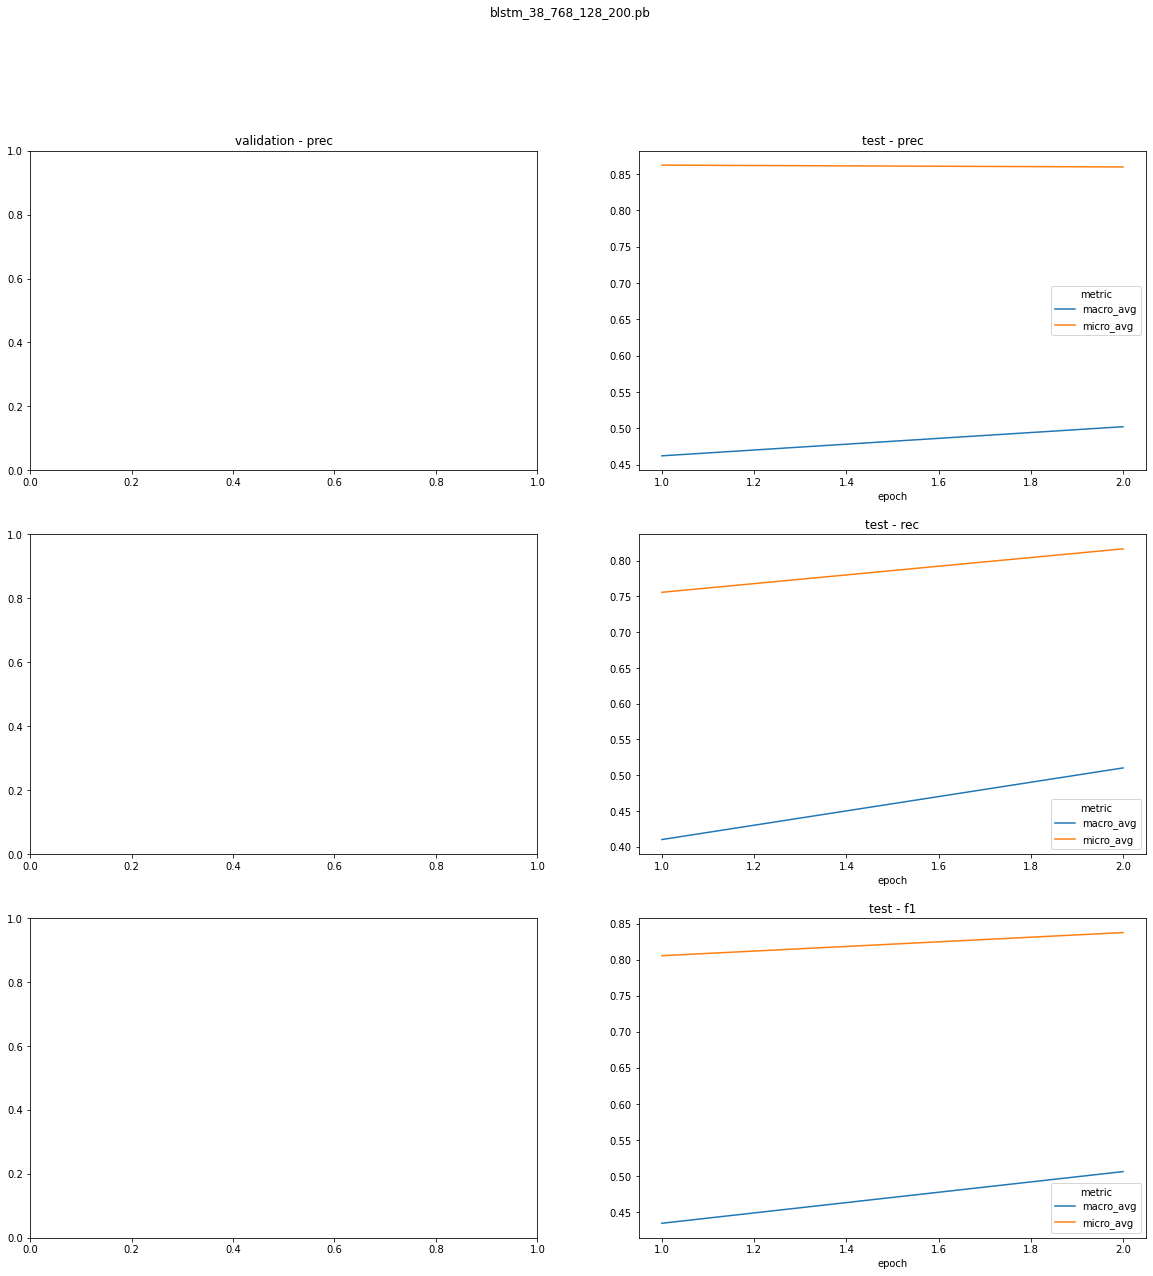

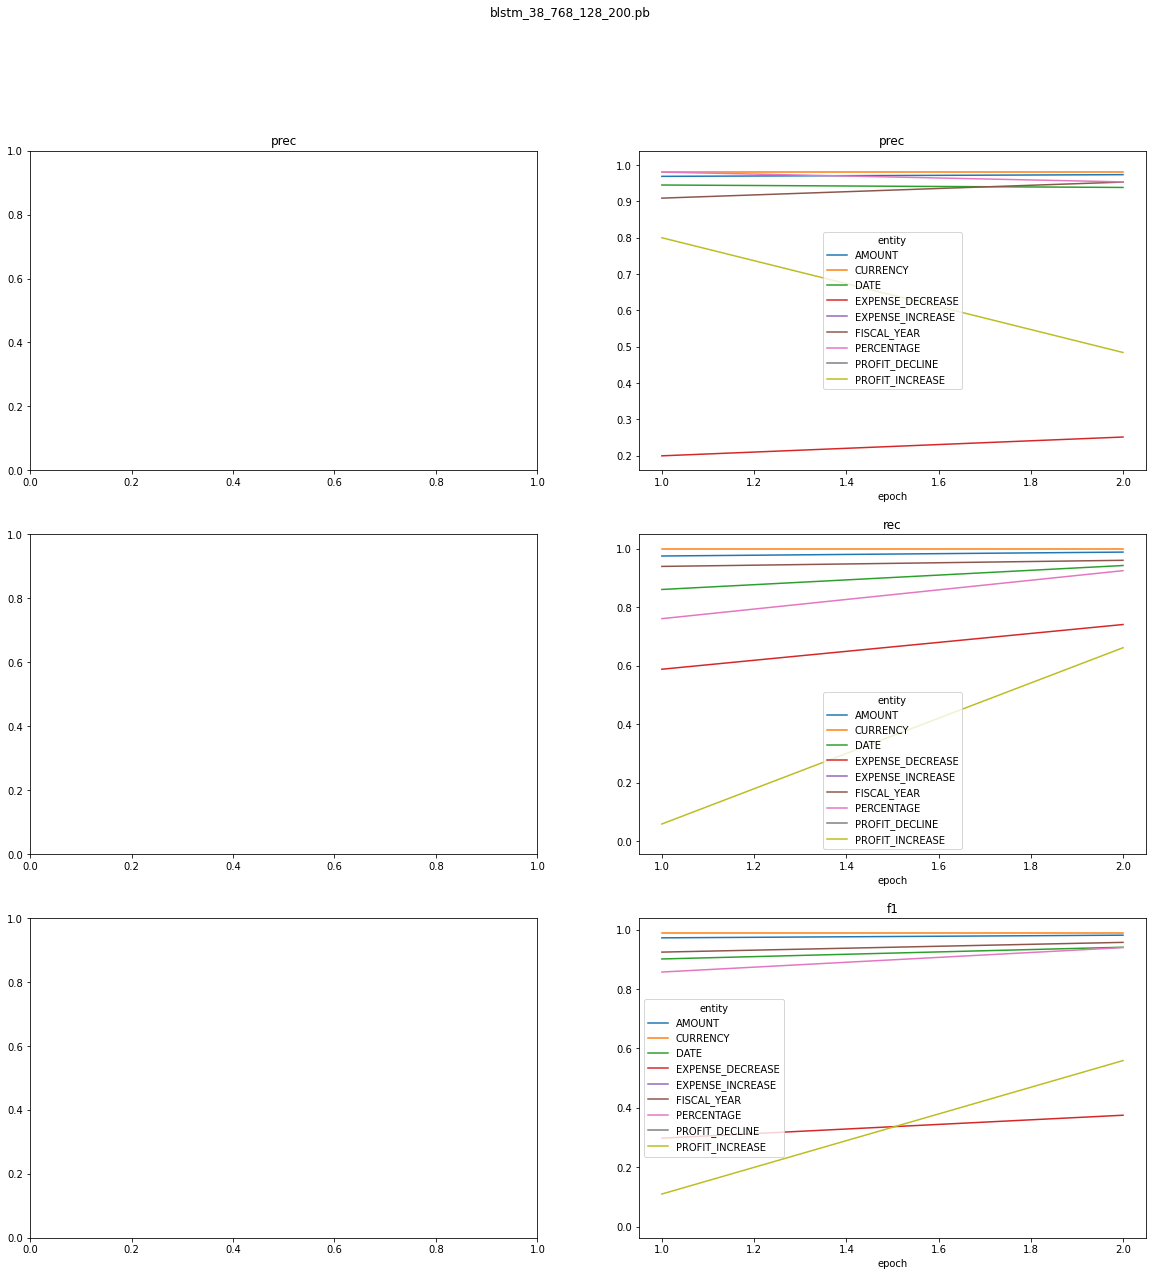

In [ ]:
import ner_log_parser

%matplotlib inline

ner_log_parser.get_charts('./ner_logs_best/'+log_files[0])

**Plotting Loss**

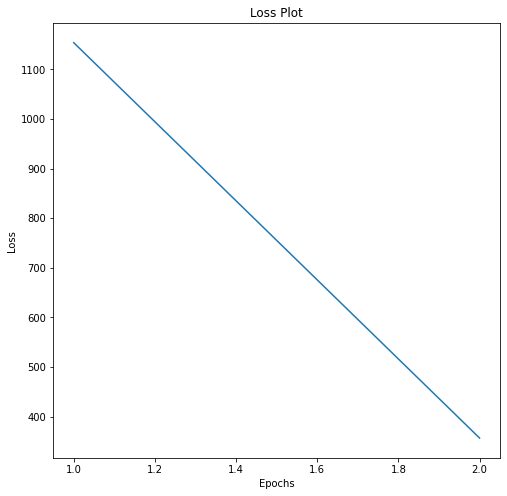

In [ ]:
ner_log_parser.loss_plot('./ner_logs_best/'+log_files[0])

###💾 Saving the trained model

In [ ]:
ner_model.stages

[BERT_EMBEDDINGS_29ce72cd673e, FinanceNerModel_80baf3edad7a]

In [ ]:
ner_model.stages[1].write().overwrite().save('NER_bert_e2_b32')

In [ ]:
!ls -lt

total 1052
drwxr-xr-x 4 root root    4096 Jan 23 20:38  NER_bert_e2_b32
drwxr-xr-x 2 root root    4096 Jan 23 20:38  __pycache__
-rw-r--r-- 1 root root    3826 Jan 23 20:38  ner_log_parser.py
-rw-r--r-- 1 root root    7431 Jan 23 20:38  conll_eval.py
drwxr-xr-x 2 root root    4096 Jan 23 20:20  ner_logs_best
drwxr-xr-x 2 root root    4096 Jan 23 19:47  ner_logs
drwxr-xr-x 2 root root    4096 Jan 23 19:37  test_data_embeddings.parquet
-rw-r--r-- 1 root root 1033219 Jan 23 19:05  conll_noO.conll
-rw-r--r-- 1 root root    1785 Jan 23 19:01 'spark_nlp_for_healthcare_spark_ocr_7162 (4).json'
drwxr-xr-x 1 root root    4096 Jan 20 14:35  sample_data


###✔️ Prediction Pipeline

In [ ]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

text_splitter = finance.TextSplitter()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = nlp.Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

bert_embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\
    .setMaxSentenceLength(512)
  
# load trained model
loaded_ner_model = finance.NerModel.load("NER_bert_e2_b32")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = finance.NerConverterInternal()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = nlp.Pipeline(
    stages = [
        document,
        text_splitter,
        token,
        bert_embeddings,
        loaded_ner_model,
        converter
    ])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

In [ ]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base .|
+---

In [ ]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,
                                    preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+-----------+--------+
|chunk      |entity  |
+-----------+--------+
|$          |CURRENCY|
|4.2 million|AMOUNT  |
+-----------+--------+



In [ ]:
light_model = nlp.LightPipeline(prediction_model)

In [ ]:
text = """$ 4.2 million of the increase was compensation related and primarily attributable to an increase in headcount to support the continued growth of our subscription SaaS offerings and ongoing maintenance and support for our expanding customer base ."""

result_ann = light_model.annotate(text)

list(zip(result_ann['token'], result_ann['ner']))

[('$', 'B-CURRENCY'),
 ('4.2', 'B-AMOUNT'),
 ('million', 'I-AMOUNT'),
 ('of', 'O'),
 ('the', 'O'),
 ('increase', 'O'),
 ('was', 'O'),
 ('compensation', 'O'),
 ('related', 'O'),
 ('and', 'O'),
 ('primarily', 'O'),
 ('attributable', 'O'),
 ('to', 'O'),
 ('an', 'O'),
 ('increase', 'O'),
 ('in', 'O'),
 ('headcount', 'O'),
 ('to', 'O'),
 ('support', 'O'),
 ('the', 'O'),
 ('continued', 'O'),
 ('growth', 'O'),
 ('of', 'O'),
 ('our', 'O'),
 ('subscription', 'O'),
 ('SaaS', 'O'),
 ('offerings', 'O'),
 ('and', 'O'),
 ('ongoing', 'O'),
 ('maintenance', 'O'),
 ('and', 'O'),
 ('support', 'O'),
 ('for', 'O'),
 ('our', 'O'),
 ('expanding', 'O'),
 ('customer', 'O'),
 ('base', 'O'),
 ('.', 'O')]

In [ ]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

sent_id         token  start  end         ner
0         0             $      0    0  B-CURRENCY
1         0           4.2      2    4    B-AMOUNT
2         0       million      6   12    I-AMOUNT
3         0            of     14   15           O
4         0           the     17   19           O
5         0      increase     21   28           O
6         0           was     30   32           O
7         0  compensation     34   45           O
8         0       related     47   53           O
9         0           and     55   57           O
10        0     primarily     59   67           O
11        0  attributable     69   80           O
12        0            to     82   83           O
13        0            an     85   86           O
14        0      increase     88   95           O
15        0            in     97   98           O
16        0     headcount    100  108           O
17        0            to    110  111           O
18        0       support    113  119           O
19        0           the    121  123           O
20        0     continued    125  133           O
21        0        growth    135  140           O
22        0            of    142  143           O
23        0           our    145  147           O
24        0  subscription    149  160           O
25        0          SaaS    162  165           O
26        0     offerings    167  175           O
27        0           and    177  179           O
28        0       ongoing    181  187           O
29        0   maintenance    189  199           O
30        0           and    201  203           O
31        0       support    205  211           O
32        0           for    213  215           O
33        0           our    217  219           O
34        0     expanding    221  229           O
35        0      customer    231  238           O
36        0          base    240  243           O
37        0             .    245  245           O

###🏉  **Highlight Entities**

In [ ]:
result = result[0]
visualiser = nlp.viz.NerVisualizer()
visualiser.display(result, label_col='ner_span', document_col='document')